# OCR Evaluation Benchmark (Still in development)

## Context

This notebook benchmarks OCR algorithms using **MaViLS (Matching Videos to Lecture Slides)**, a dataset of lecture videos paired with the original slide PDFs and sentence-level timestamped annotations that map spoken segments to slide identities.

MaViLS is well suited for OCR evaluation because it naturally creates a **clean vs noisy text pairing**. Slides provide high quality text sources, while video frames contain the same content under real capture conditions such as blur, compression artifacts, perspective distortion, and low contrast. This makes it possible to measure robustness to domain shift and quantify how OCR quality impacts an end task, namely **retrieving or aligning the correct slide from video content**.


## Models

We benchmark different groups of algorithms:

- **Transformer based OCR (TrOCR)** (`trocr-base-printed`, `trocr-base-handwritten`): recognition-first, sequence-to-sequence transformer models that directly map an image crop to text. Strong language modeling and robustness to moderate noise, with separate variants specialized for printed versus handwritten text.

- **Classical OCR engine (Tesseract)** (`tesseract`, `tesseract@eng,psm=6,oem=3`): a mature OCR pipeline with explicit layout assumptions and extensive heuristics. Performance is highly sensitive to configuration, so including both default and tuned settings highlights the impact of language selection, segmentation strategy, and engine mode.

- **Deep learning OCR baseline (EasyOCR)** (`easyocr_en`): a general-purpose neural OCR system combining text detection and recognition. Typically more resilient than classical OCR on low-quality imagery while remaining straightforward to run.

- **End-to-end document OCR stacks (DocTR)** (`doctr_linknet_resnet18_vitstr_small`, `doctr_db_resnet50_crnn_vgg16_bn`): modular detector plus recognizer pipelines designed for document images. The two configurations contrast an efficiency-oriented setup with a higher-capacity stack, enabling speed versus accuracy comparisons under identical evaluation metrics.



## Objectives

- Compare OCR models on transcription quality and runtime.
- Decompose errors into substitutions, deletions, and insertions.
- Inspect tail behavior (hard samples) and model disagreement.
- Measure performance as a function of reference length.

## Metrics

We evaluate OCR output with two edit-distance metrics computed against the reference text.

- **Word Error Rate (WER)** measures token-level mistakes. Let $S$ be substitutions, $D$ deletions, $I$ insertions, and $N$ the number of reference words:

$$
\mathrm{WER} = \frac{S + D + I}{N}
$$

- **Character Error Rate (CER)** measures character-level mistakes. Using the same edit counts and letting $N$ be the number of reference characters:

$$
\mathrm{CER} = \frac{S + D + I}{N}
$$

Corpus-level scores are computed by summing $S$, $D$, $I$, and $N$ over the full dataset, then applying the formula once to the aggregated totals.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from eval_notebook_utils import *  

results_root = "results"
dataset = "mavils"

palette = make_palette(ocr_model_family) 

In [19]:
df = load_eval_df(results_root, dataset, ocr_wer_spec)  # noqa: F405
df.head()

,model,dataset,id,lecture,timestamp_s,slide_label,image_path,cer,wer,word_substitutions,...,word_insertions,ref_words,hyp_words,char_substitutions,char_deletions,char_insertions,ref_chars,hyp_chars,ocr_seconds,err_units
0,doctr_db_resnet50_crnn_vgg16_bn,mavils,teamdynamicsgamedesignmitgroundtruthlabeledcon...,teamdynamicsgamedesignmitgroundtruthlabeledcon...,3.06,1,ocr_frames\teamdynamicsgamedesignmitgroundtrut...,1.975610,1.259259,27,...,7,27,34,101,0,142,123,298,0.9314,34
1,doctr_db_resnet50_crnn_vgg16_bn,mavils,teamdynamicsgamedesignmitgroundtruthlabeledcon...,teamdynamicsgamedesignmitgroundtruthlabeledcon...,9.66,1,ocr_frames\teamdynamicsgamedesignmitgroundtrut...,0.821138,1.000000,25,...,1,27,27,91,7,3,123,145,0.6516,27
2,doctr_db_resnet50_crnn_vgg16_bn,mavils,teamdynamicsgamedesignmitgroundtruthlabeledcon...,teamdynamicsgamedesignmitgroundtruthlabeledcon...,23.75,1,ocr_frames\teamdynamicsgamedesignmitgroundtrut...,0.902439,1.074074,27,...,2,27,29,82,10,19,123,160,0.6571,29
3,doctr_db_resnet50_crnn_vgg16_bn,mavils,teamdynamicsgamedesignmitgroundtruthlabeledcon...,teamdynamicsgamedesignmitgroundtruthlabeledcon...,27.70,1,ocr_frames\teamdynamicsgamedesignmitgroundtrut...,0.902439,1.074074,27,...,2,27,29,82,10,19,123,160,0.6551,29
4,doctr_db_resnet50_crnn_vgg16_bn,mavils,teamdynamicsgamedesignmitgroundtruthlabeledcon...,teamdynamicsgamedesignmitgroundtruthlabeledcon...,39.93,1,ocr_frames\teamdynamicsgamedesignmitgroundtrut...,4.341463,4.592593,26,...,98,27,125,34,1,499,123,745,1.1129,124


In [20]:
summary_wer = summarize_eval_df(df, ocr_wer_spec) 
order_wer = make_order(summary_wer)  
summary_cer = summarize_eval_df(df, ocr_cer_spec)  
order_cer = make_order(summary_cer)  
summary_wer

,model,n_items,total_ref_len,total_S,total_D,total_I,total_err,mean_item_metric,median_item_metric,p90_item_metric,total_runtime_seconds,median_runtime_seconds,p90_runtime_seconds,corpus_metric,sec_per_ref_unit,S_per_unit,D_per_unit,I_per_unit
0,trocr-base-handwritten,556,38151,934,37011,0,37945,0.996637,1.0,1.000000,24.9396,0.04150,0.05245,0.994600,0.000654,0.024482,0.970119,0.000000
1,trocr-base-printed,556,38151,453,37655,0,38108,0.999340,1.0,1.000000,26.8276,0.04455,0.06055,0.998873,0.000703,0.011874,0.986999,0.000000
2,tesseract,556,38151,14702,22609,10122,47433,1.679014,1.0,2.955357,136.3823,0.22485,0.36180,1.243296,0.003575,0.385363,0.592619,0.265314
3,"tesseract@eng,psm=6,oem=3",556,38151,14702,22609,10122,47433,1.679014,1.0,2.955357,133.8771,0.21870,0.34870,1.243296,0.003509,0.385363,0.592619,0.265314
4,easyocr_en,556,38151,16890,20555,12784,50229,1.846705,1.0,3.074074,131.0745,0.19495,0.39975,1.316584,0.003436,0.442714,0.538780,0.335090
5,doctr_linknet_resnet18_vitstr_small,556,38151,17410,19762,15353,52525,1.989329,1.0,3.523810,468.9792,0.72095,1.52185,1.376766,0.012293,0.456345,0.517994,0.402427
6,doctr_db_resnet50_crnn_vgg16_bn,556,38151,17274,19921,15592,52787,1.996097,1.0,3.211111,441.8862,0.75615,1.05990,1.383633,0.011583,0.452780,0.522162,0.408692


In [25]:
list(summary_wer["model"])

['trocr-base-handwritten',
 'trocr-base-printed',
 'tesseract',
 'tesseract@eng,psm=6,oem=3',
 'easyocr_en',
 'doctr_linknet_resnet18_vitstr_small',
 'doctr_db_resnet50_crnn_vgg16_bn']

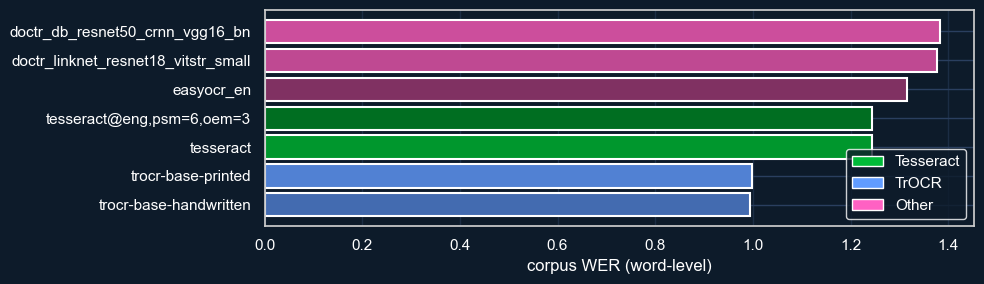

In [21]:
fig, ax = plot_corpus_metric_barh(  # noqa: F405
    summary_wer,
    order_wer,
    palette,
    xlabel="corpus WER (word-level)",
)
plt.show()

## Corpus CER

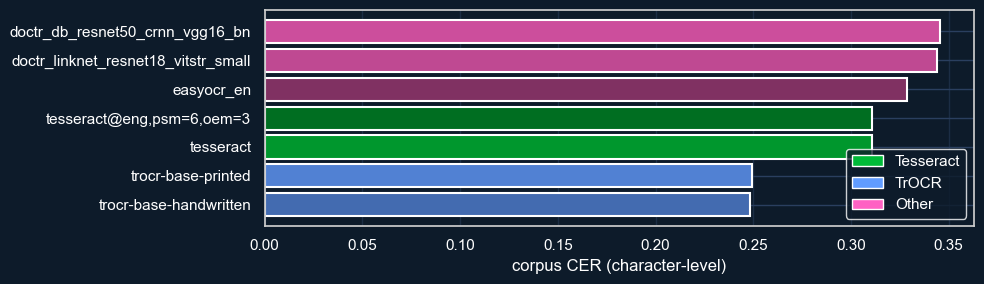

In [22]:
fig, ax = plot_corpus_metric_barh(  # noqa: F405
    summary_cer,
    order_cer,
    palette,
    xlabel="corpus CER (character-level)",
)
plt.show()

## Latency vs corpus WER

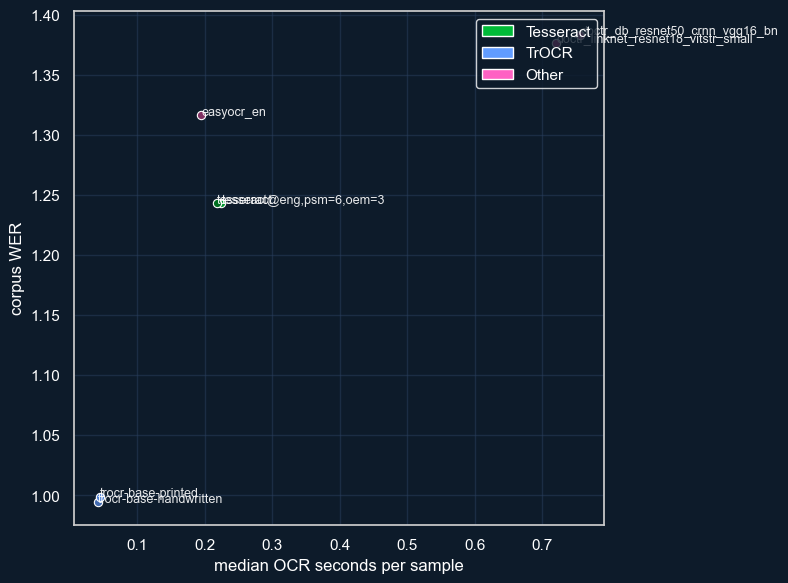

In [23]:
fig, ax = plot_latency_vs_metric(  # noqa: F405
    summary_wer,
    order_wer,
    palette,
    xlabel="median OCR seconds per sample",
    ylabel="corpus WER",
)
plt.show()

## Latency vs corpus CER

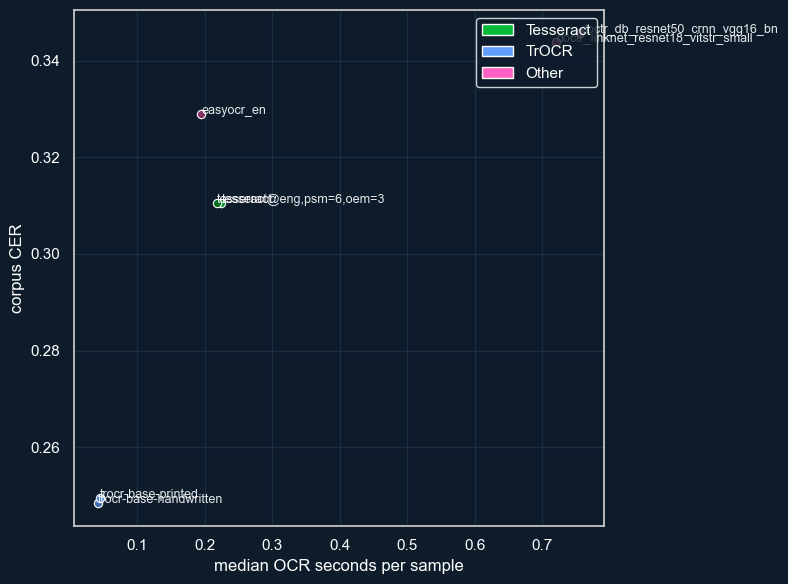

In [8]:
fig, ax = plot_latency_vs_metric(  # noqa: F405
    summary_cer,
    order_cer,
    palette,
    xlabel="median OCR seconds per sample",
    ylabel="corpus CER",
)
plt.show()

## Empirical CDF (WER)

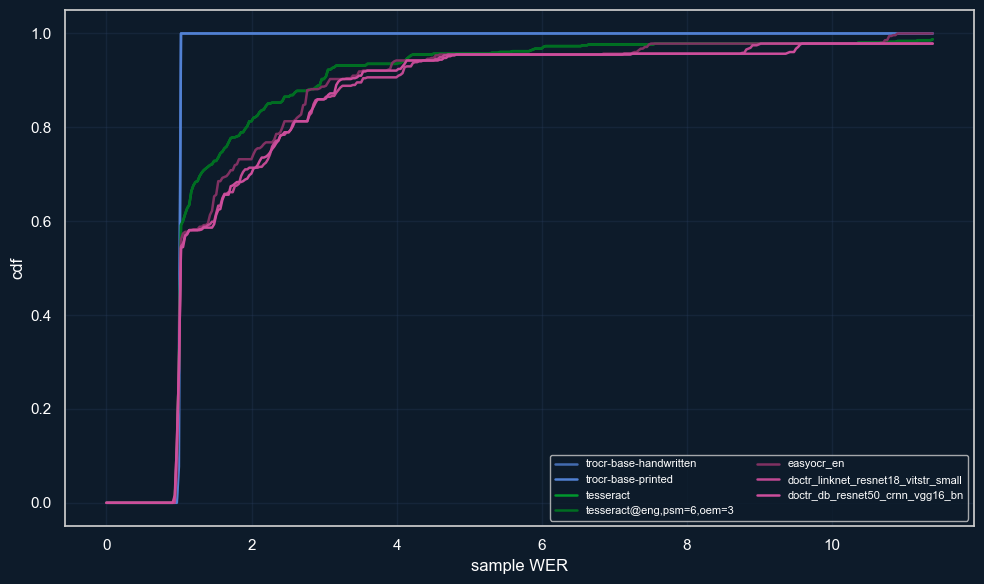

In [9]:
fig, ax = plot_metric_cdf(  # noqa: F405
    df,
    order_wer,
    palette,
    metric_col="wer",
    xlabel="sample WER",
)
plt.show()

## Empirical CDF (CER)

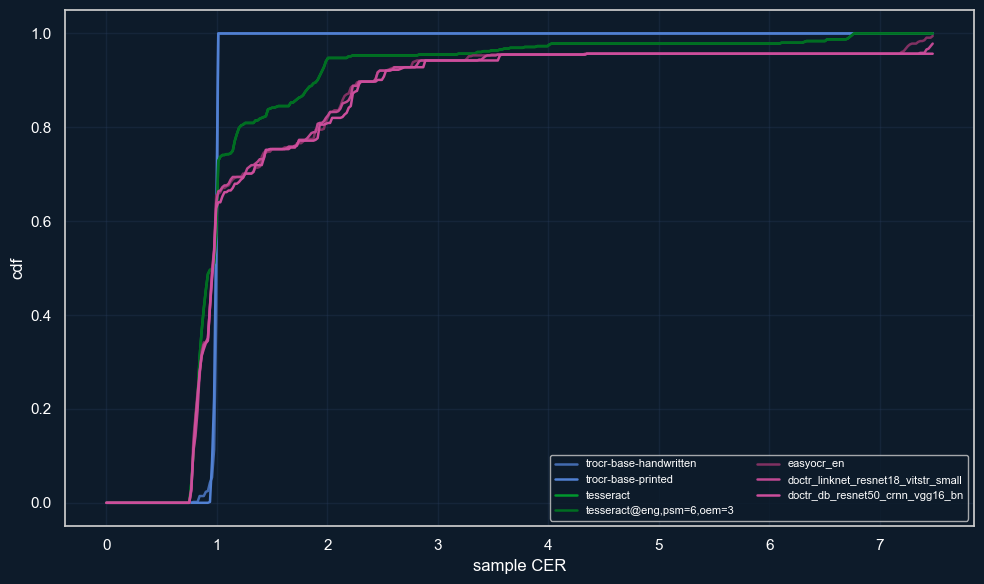

In [10]:
fig, ax = plot_metric_cdf(  # noqa: F405
    df,
    order_cer,
    palette,
    metric_col="cer",
    xlabel="sample CER",
)
plt.show()

## Oracle win counts

In [11]:
win_wer = oracle_win_counts(df, order_wer, metric_col="wer", tie_mode="fractional")  # noqa: F405
win_wer

,model,n_wins,win_share
0,trocr-base-handwritten,168.564286,0.303173
1,trocr-base-printed,144.064286,0.259108
2,doctr_db_resnet50_crnn_vgg16_bn,58.897619,0.105931
3,tesseract,51.547619,0.092712
4,"tesseract@eng,psm=6,oem=3",51.547619,0.092712
5,doctr_linknet_resnet18_vitstr_small,48.614286,0.087436
6,easyocr_en,32.764286,0.058929


In [12]:
win_cer = oracle_win_counts(df, order_cer, metric_col="cer", tie_mode="fractional")  # noqa: F405
win_cer

,model,n_wins,win_share
0,trocr-base-printed,113.500000,0.204137
1,easyocr_en,97.233333,0.174880
2,doctr_db_resnet50_crnn_vgg16_bn,88.733333,0.159592
3,doctr_linknet_resnet18_vitstr_small,86.066667,0.154796
4,tesseract,63.733333,0.114628
5,"tesseract@eng,psm=6,oem=3",63.733333,0.114628
6,trocr-base-handwritten,43.000000,0.077338


## Metric by reference length bins

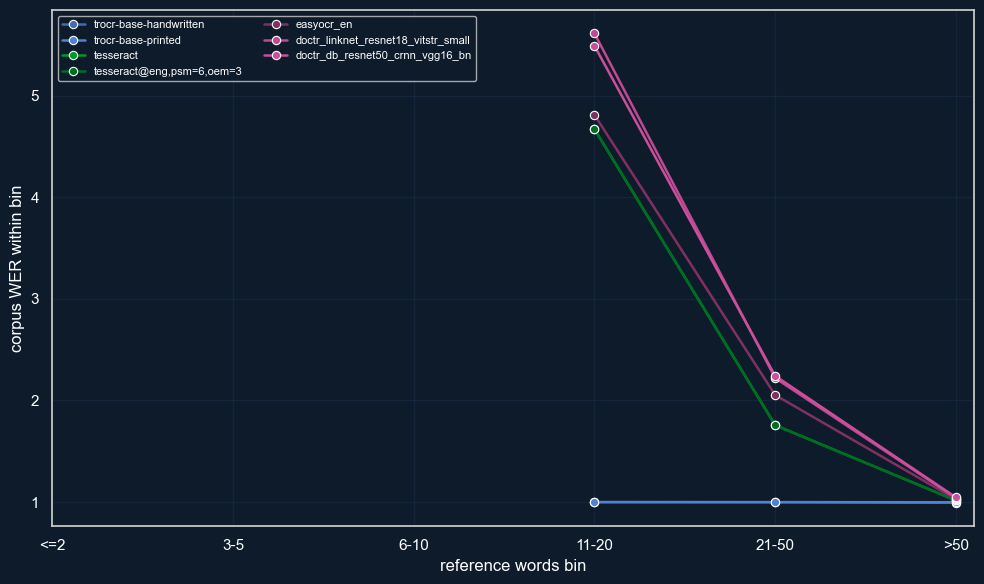

In [13]:
pivot_wer, labels, _ = metric_by_length_pivot(  # noqa: F405
    df,
    order_wer,
    palette,
    ref_len_col="ref_words",
    return_data=True,
)
fig, ax = plot_metric_by_length(  # noqa: F405
    pivot_wer,
    labels,
    order_wer,
    palette,
    xlabel="reference words bin",
    ylabel="corpus WER within bin",
)
plt.show()

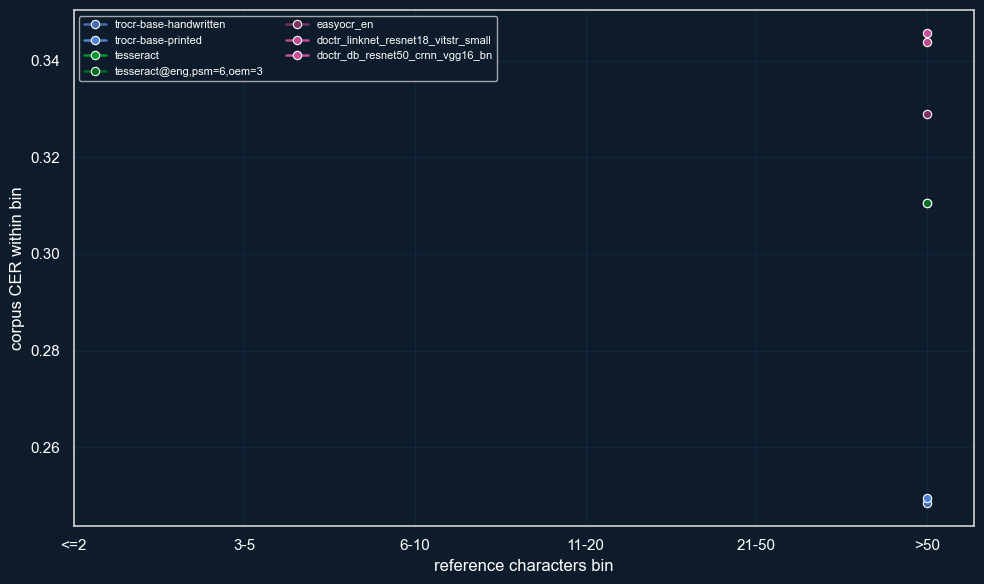

In [14]:
pivot_cer, labels, _ = metric_by_length_pivot(  # noqa: F405
    df,
    order_cer,
    palette,
    ref_len_col="ref_chars",
    return_data=True,
)
fig, ax = plot_metric_by_length(  # noqa: F405
    pivot_cer,
    labels,
    order_cer,
    palette,
    xlabel="reference characters bin",
    ylabel="corpus CER within bin",
)
plt.show()


## Compact summary tables

In [15]:
display_cols = [
    "model",
    "n_items",
    "corpus_metric",
    "mean_item_metric",
    "median_item_metric",
    "p90_item_metric",
    "median_runtime_seconds",
    "sec_per_ref_unit",
    "S_per_unit",
    "D_per_unit",
    "I_per_unit",
]

tbl_wer = summary_wer[display_cols].copy()
tbl_wer = tbl_wer.rename(columns={"corpus_metric": "corpus_wer"})
tbl_wer


,model,n_items,corpus_wer,mean_item_metric,median_item_metric,p90_item_metric,median_runtime_seconds,sec_per_ref_unit,S_per_unit,D_per_unit,I_per_unit
0,trocr-base-handwritten,556,0.994600,0.996637,1.0,1.000000,0.04150,0.000654,0.024482,0.970119,0.000000
1,trocr-base-printed,556,0.998873,0.999340,1.0,1.000000,0.04455,0.000703,0.011874,0.986999,0.000000
2,tesseract,556,1.243296,1.679014,1.0,2.955357,0.22485,0.003575,0.385363,0.592619,0.265314
3,"tesseract@eng,psm=6,oem=3",556,1.243296,1.679014,1.0,2.955357,0.21870,0.003509,0.385363,0.592619,0.265314
4,easyocr_en,556,1.316584,1.846705,1.0,3.074074,0.19495,0.003436,0.442714,0.538780,0.335090
5,doctr_linknet_resnet18_vitstr_small,556,1.376766,1.989329,1.0,3.523810,0.72095,0.012293,0.456345,0.517994,0.402427
6,doctr_db_resnet50_crnn_vgg16_bn,556,1.383633,1.996097,1.0,3.211111,0.75615,0.011583,0.452780,0.522162,0.408692


In [16]:
tbl_cer = summary_cer[display_cols].copy()
tbl_cer = tbl_cer.rename(columns={"corpus_metric": "corpus_cer"})
tbl_cer

,model,n_items,corpus_cer,mean_item_metric,median_item_metric,p90_item_metric,median_runtime_seconds,sec_per_ref_unit,S_per_unit,D_per_unit,I_per_unit
0,trocr-base-handwritten,556,0.248466,0.987940,0.996357,1.000000,0.04150,0.000163,0.006489,0.983034,0.000065
1,trocr-base-printed,556,0.249533,0.985946,0.991489,1.000000,0.04455,0.000176,0.000897,0.988403,0.000000
2,tesseract,556,0.310594,1.221428,0.961156,1.899281,0.22485,0.000893,0.257699,0.548138,0.256481
3,"tesseract@eng,psm=6,oem=3",556,0.310594,1.221428,0.961156,1.899281,0.21870,0.000877,0.257699,0.548138,0.256481
4,easyocr_en,556,0.328902,1.471381,0.953425,2.426829,0.19495,0.000858,0.312244,0.451260,0.431118
5,doctr_linknet_resnet18_vitstr_small,556,0.343937,1.480326,0.956835,2.430894,0.72095,0.003071,0.308813,0.455503,0.436828
6,doctr_db_resnet50_crnn_vgg16_bn,556,0.345652,1.519837,0.959037,2.453237,0.75615,0.002893,0.310155,0.449380,0.465325
